DESCRIPTION: Pneumonia is an infection that affects one or both lungs by causing the air sacs, or alveoli, of the lungs to fill up with fluid or pus. Traditionally, pneumonia detection hinges on the examination of chest X-ray radiographs, a labor-intensive process conducted by highly skilled specialists. This method often results in discordant interpretations among radiologists. Leveraging the power of deep learning techniques (CNNs), we have developed a computational approach for the detection of pneumonia regions.

OBJECTIVE: Create a model that classifies x-ray images into two categories: Normal and Pneumonia. This information can be used by medical experts to assist in the diagnosis of pneumonia.

METHODOLOGY: We used Convolutional Neural Network (CNN) techniques to develop an AI system for pneumonia detection. The neural network model or architecture was designed using the Keras API and was implemented using Python and TensorFlow.

DATA: The dataset was provided by Kaggle: Chest X-Ray Images (Pneumonia). It contains X-ray three folders/directories (train, test, val) of images divided into two categories: "Normal" and "Pneumonia." These images were acquired from pediatric patients aged one to five years at Guangzhou Women and Children's Medical Center. Before inclusion, a quality control process removed poor-quality scans, and expert physicians graded the diagnoses to prepare the dataset for AI training.



# 1. **Loading In and Exploring the Data**

First, we need to create our directory paths to input into our image generators. Then we need to create the datasets.



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, optimizers, regularizers, callbacks
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import Recall, Precision

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Directory paths for train, test, and val
train_path = '/content/drive/MyDrive/chest_xray/chest_xray/train'
test_path = '/content/drive/MyDrive/chest_xray/chest_xray/test'
val_path = '/content/drive/MyDrive/chest_xray/chest_xray/val'

# Import the train directory data, which includes both normal and pneumonia (5216 total) and reshape them
train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        train_path,
        target_size=(64, 64), batch_size=5216)

# Import the test directory data, which includes both normal and pneumonia (624 total) and reshape them
test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        test_path,
        target_size=(64, 64), batch_size=624)

# Import the val directory data, which includes both normal and pneumonia (8 each - 16 total) and reshape them
val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        val_path,
        target_size=(64, 64), batch_size=16)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Note that I took care of standarizing the data by using rescale in the ImageDataGenerator functions. Each image takes a value between 0 and 255 so to standardize the data, I divided by 255.

It takes about 13 minutes to run this code block.

Now that I have the data loaded in, let's take a look at some of the images from each dataset, just to check they loaded properly and are visible.

First, let's look at a few train images:



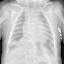

In [ ]:
array_to_img(train_images[0])

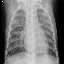

In [ ]:
array_to_img(train_images[4])

Looks good! Now, let's look at some test images:

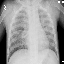

In [ ]:
array_to_img(test_images[0])

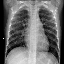

In [ ]:
array_to_img(test_images[4])

Looks good! Finally, let's look at the validation images:

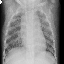

In [ ]:
array_to_img(val_images[0])

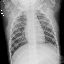

In [ ]:
array_to_img(val_images[4])

Great! All of our pictures have loaded, and are visible. Let's check out the distribution of pneumonia vs. normal images in our train dataset.

First, let's create paths to where the normal and pneumonia folders are saved.

In [ ]:
normal_train_path = ('/content/drive/MyDrive/chest_xray/chest_xray/train/NORMAL')
pneumonia_train_path = ('/content/drive/MyDrive/chest_xray/chest_xray/train/PNEUMONIA')

Next, let's count how many files are in each folder so that we can plot the distribution.

In [ ]:
normal_count = len(os.listdir(normal_train_path))
pneumonia_count = len(os.listdir(pneumonia_train_path))
print(f'normal: {normal_count}')
print(f'pneumonia: {pneumonia_count}')

normal: 1342
pneumonia: 3876


Plot the data

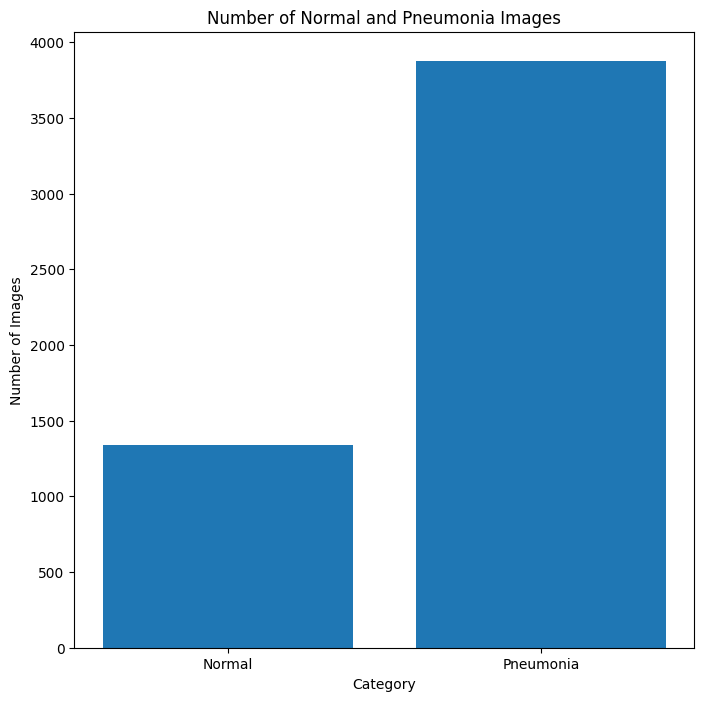

In [ ]:
# plot the distribution
fig, ax = plt.subplots(figsize=(8,8))
plt.bar(x=['Normal', 'Pneumonia'], height=[normal_count, pneumonia_count])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Normal and Pneumonia Images')
plt.show();

Here, I can clearly see that are a lot more images of pneumonia than there are images of normal chests. Since the model will always predict class 1, to prevent the model from just predicting pneumonia (the majority class) every time, it might be beneficial to switch the labels, so that our normal images are class 1, pneumonia is class 0, and our model is aiming to predict if an x-ray is normal.

Before I do anything, let's check out the shape of the datasets and see what I are working with.



In [ ]:
print(f"Train Images: {train_images.shape}")
print(f"Train Labels: {train_labels.shape}")
print(f"Test Images: {test_images.shape}")
print(f"Test Labels: {test_labels.shape}")
print(f"Val Images: {val_images.shape}")
print(f"Val Labels: {val_labels.shape}")

Train Images: (5216, 64, 64, 3)
Train Labels: (5216, 2)
Test Images: (624, 64, 64, 3)
Test Labels: (624, 2)
Val Images: (16, 64, 64, 3)
Val Labels: (16, 2)


Let's also look at the class indices to find out how are images are labeled.

In [ ]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Here, we'd like to point out a few things:

There are two classes in our dataset: the first is normal, which is class 0, and the second is pneumonia, which is class 1. So, 0 represents a normal x-ray with no pneumonia and 1 represents an x-ray of a chest with pneumonia.
The shape of the labels are (x, 2) where x represents the row and there are 2 columns. This represents the binary class labels, likely being represented as an array [0,1] or [1,0] with 0 representing normal and 1 representing pneumonia.
Let's confirm #2, and then change the labels to be either 0 or 1 based on if the x-ray is normal or not.



In [ ]:
train_labels

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

Yes! The labels are an array of [0,1] or [1,0]. I want the model to be a binary classification so let's change the labels to be binary instead. From earlier, I would like normal to be class 1, so if I take the first row of the transposed dataset, it should correspond to normal.

In [ ]:
# transpose the train labels so we have two rows
# take the first row, which represents normal, and set that equal to our final labels
train_labels_final = train_labels.T[0]
test_labels_final = test_labels.T[0]
val_labels_final = val_labels.T[0]

print(f"Train Labels Updated Shape: {train_labels_final.shape}")
print(f"Test Labels Updated Shape: {test_labels_final.shape}")
print(f"Val Labels Updated Shape: {val_labels_final.shape}")

Train Labels Updated Shape: (5216,)
Test Labels Updated Shape: (624,)
Val Labels Updated Shape: (16,)


In [ ]:
train_labels_final

array([0., 0., 1., ..., 0., 0., 1.], dtype=float32)

Great! Just to be sure, let's confirm how many are labeled as 0 and how many are labeled as 1 so that we know what we're predicting.

In [ ]:
distribution = np.bincount(train_labels_final.astype(int))
print("Class 0 count:", distribution[0])
print("Class 1 count:", distribution[1])

Class 0 count: 3875
Class 1 count: 1341


In [ ]:
pd.Series(train_labels_final).value_counts(normalize=True)

,proportion
0.0,0.742906
1.0,0.257094


So, the  dataset is made up of 75% pneumonia images, and 25% normal images. Since I am predicting class 1 (normal), 25% is the accuracy thats need to beat.

Let's get started with our first simple model!

# **2. First Simple Model**

Let's build a first simple model with no hidden layers. We're going to use the sequential model from keras, as it allows us to stack layers one after the other. Starting with a dense layer with 10 units, relu activation as it will introduce some non-linearity into our model to help it learn complex patterns, and an input shape of (64, 64, 3). Then adding a flattening layer so that the output layer of the previous dense layer (which is 2D) is turned into a 1D tensor, which is what our output layer needs. Then I will add a final dense layer with 1 unit and sigmoid activation, as that is what is suitable for binary classification.

In [ ]:
first_model = models.Sequential()
first_model.add(layers.Dense(10, activation='relu', input_shape=(64, 64, 3)))
first_model.add(layers.Flatten())
first_model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let's compile the model using the adam optimizer, binary crossentropy as the loss, and accuracy as our metric.

I chose adam because adam is an adaptive learning rate optimization algorithm that helps with efficient convergence.
I chose binary crossentropy because this is a binary classification!
I would like to measure the accuracy in our results, hence our metric of choice.

In [ ]:
first_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Let's check out

In [ ]:
first_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64, 64, 10)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        40,961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,001 (160.16 KB)

 Trainable params: 41,001 (160.16 KB)

 Non-trainable params: 0 (0.00 B)

# The model has 41,001 parameters, all trainable. Let's fit it on our train set, and see how it does.

In [ ]:
train_loss, train_acc = first_model.evaluate(train_images, train_labels_final)

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7448 - loss: 0.5613


I have a train score of 94% and a test score of 70%. This is nice and overfit! Let's try using a Conv2D layer to start, and add a hiden Conv2D layer, and see if that helps improve our accuracy.

Since I have a relatively smaller dataset, I going to use 32 filters for our first convolutional layer. This means that we have 32 "detectors", each looking for a different pattern in the images. Let's keep relu activation for now in our first and hidden layer, and keep sigmoid as our output activation.



In [ ]:
second_model = models.Sequential()
second_model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 3)))

second_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

second_model.add(layers.Flatten())
second_model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the model the same way as before - adam optimizer, binary crossentropy as the loss, and accuracy as our metric. Then, fit it on our training data.

In [ ]:
second_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
second_model.fit(train_images,train_labels_final,epochs=10,batch_size=64)


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 69s 825ms/step - accuracy: 0.7117 - loss: 0.8117
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 68s 831ms/step - accuracy: 0.9591 - loss: 0.1116
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 79s 798ms/step - accuracy: 0.9598 - loss: 0.0988
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 87s 859ms/step - accuracy: 0.9687 - loss: 0.0782
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 68s 831ms/step - accuracy: 0.9644 - loss: 0.0986
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 66s 802ms/step - accuracy: 0.9810 - loss: 0.0550
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 84s 819ms/step - accuracy: 0.9845 - loss: 0.0421
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 84s 846ms/step - accuracy: 0.9899 - loss: 0.0301
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 80s 817ms/step - accuracy: 0.9885 - loss: 0.0306
Epoch 10/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 68s 833ms/step - accuracy: 0.9947 - loss: 0.0164


In [ ]:
train_loss, train_acc = second_model.evaluate(train_images, train_labels_final)

163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.9993 - loss: 0.0109


In [ ]:
test_loss, test_acc = second_model.evaluate(test_images, test_labels_final)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.7133 - loss: 2.1486


I trained the score of nearly 1, and a test score of about 71%. The test score is better, but the train score is even more overfit than before! Let's try adding regularization next.

Before I do that, however, I going to be checking scores quite a lot. So, let's define a function to evaluate our models for moving forward

In [ ]:
def evaluate(model):
    model_results_train = model.evaluate(train_images, train_labels_final)
    print(f'Training Loss: {model_results_train[0]:.3} \nTraining Accuracy: {model_results_train[1]:.3}')

    print('----------')

    model_results_test = model.evaluate(test_images, test_labels_final)
    print(f'Test Loss: {model_results_test[0]:.3} \nTest Accuracy: {model_results_test[1]:.3}')

Let's just check that this function works by using it on our second model, and comparing to the manually calculated results above.

In [ ]:
evaluate(second_model)

163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9993 - loss: 0.0109
Training Loss: 0.00984 
Training Accuracy: 0.999
----------
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.7133 - loss: 2.1486
Test Loss: 1.96 
Test Accuracy: 0.715


Great! The function works. As mentioned before, our model is very overfit, and I would like to add regularization to see if it improves performance.

Let's start with L2 regularization. L2 (or Ridge regularization) works by adding a penalty term to the loss function, which in turn makes the models weights smaller. It effectively limits the models capacity, which reduces overfitting. It also improves generalization - the limit of the weights helps the models performance with unseen data. It's important to note that L2 regularization drives the weights towards 0, reducing their influence on the models predicitons.

Let's use our second_model, and just adjust it to include regularization. Let's start with a smaller strength of 0.005.

In [ ]:
third_model = models.Sequential()

third_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3),
                               activation='relu', kernel_regularizer=regularizers.l2(0.005),
                               input_shape=(64, 64, 3)))

third_model.add(layers.Flatten())
third_model.add(layers.Dense(1, activation='sigmoid'))

Compile the model using adam, binary crossentropy, and accuracy once more.

In [ ]:
third_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Fit the model on our train data and let's analyze the results.

In [ ]:
# This cell may take about a minute to run
third_model_results = third_model.fit(train_images,train_labels_final,epochs=10,batch_size=64)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.7679 - loss: 0.7102
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9557 - loss: 0.1535
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9687 - loss: 0.1206
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.9719 - loss: 0.1014
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.9778 - loss: 0.0925
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.9754 - loss: 0.0901
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.9837 - loss: 0.0745
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.9914 - loss: 0.0579
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.9902 - loss: 0.0578
Epoch 10/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.9959 - loss: 0.0472


In [ ]:
# This cell may take about a minute to run
evaluate(third_model)

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9950 - loss: 0.0528
Training Loss: 0.0495 
Training Accuracy: 0.996
----------
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7635 - loss: 0.9406
Test Loss: 0.838 
Test Accuracy: 0.774


This model is a little bit better than the previous two, but not a whole lot. Our train score is still nearly 1 (99%), and our test score is 79%. This test score is an improvement, but as our train score is 20% higher, this model is still very overfit.

Let's try adding dropout regularization. Dropout works by randomly deactivating (or "dropping out") a certain number of units (or neurons) during each forward/backward propagation of training. This introduces some randomness into our model, and helps prevent any one neuron from being too over-trained. This ultimately helps the model generalize better to unseen data.

So, let's see if it helps! Let's also add a few more hidden layers, as more complexity should help generalization. We'll add both convolutional and pooling layers. The pooling layers aim to reduce the spacial dimensions of the feature maps created by the convolutional layers. It preserves the most important pieces of information from the feature maps.

In [ ]:
#DROPOUT METHOD TO MITIGATE THE IMPACTS OF OVERFITTING
# This cell may take about a minute to run
fourth_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
fourth_model.add(layers.Dropout(0.3, input_shape=(64,64,3)))

# Add the first hidden layer
fourth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

# Implement dropout to the first hidden layer
fourth_model.add(layers.Dropout(.3))

# Add the second hidden layer
fourth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
fourth_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Implement dropout to the second hidden layer
fourth_model.add(layers.Dropout(.3))

# Add the output layer
fourth_model.add(layers.Flatten())
fourth_model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Next, let's compile, fit, and evaluate our model!

In [ ]:
fourth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# This cell may take about a minute to run
fourth_model_results = fourth_model.fit(train_images,train_labels_final,epochs=10,batch_size=64)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.7353 - loss: 0.5694
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 445ms/step - accuracy: 0.9352 - loss: 0.1585
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 34s 417ms/step - accuracy: 0.9458 - loss: 0.1323
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 36s 439ms/step - accuracy: 0.9468 - loss: 0.1383
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 422ms/step - accuracy: 0.9537 - loss: 0.1212
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 36s 444ms/step - accuracy: 0.9558 - loss: 0.1077
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 445ms/step - accuracy: 0.9604 - loss: 0.1063
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 427ms/step - accuracy: 0.9658 - loss: 0.0863
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 500ms/step - accuracy: 0.9727 - loss: 0.0796
Epoch 10/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 35s 423ms/step - accuracy: 0.9658 - loss: 0.0866


In [ ]:
# ⏰ This cell may take about a minute to run
evaluate(fourth_model)

163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9742 - loss: 0.1143
Training Loss: 0.112 
Training Accuracy: 0.974
----------
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7134 - loss: 0.6360
Test Loss: 0.581 
Test Accuracy: 0.724


Okay, so that didn't help. Interesting. The train score is slightly lower at 97%, and our test score is back down to 76%. So this isn't any better or worse than our previous models.

Let's try adding an additional hidden layer and see if the increased complexity helps. I would also like to try switching the activation function to tanh instead of relu and see if that helps anything.

Tanh has similar properties to the sigmoid activation function, but rather than range from (0,1) like sigmoid, it ranges from (-1, 1), making it centered around zero.

Okay, so that didn't help. Interesting. The train score is slightly lower at 97%, and our test score is back down to 72%. So this isn't any better or worse than our previous models.

Let's try adding an additional hidden layer and see if the increased complexity helps. We'd also like to try switching the activation function to tanh instead of relu and see if that helps anything.

Tanh has similar properties to the sigmoid activation function, but rather than range from (0,1) like sigmoid, it ranges from (-1, 1), making it centered around zero.

In [ ]:
fifth_model = models.Sequential()

fifth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
fifth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='tanh'))

# Implement dropout to the first hidden layer
fifth_model.add(layers.Dropout(.3))

# Add the second hidden layer
fifth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
fifth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the second hidden layer
fifth_model.add(layers.Dropout(.3))

# Add the third hidden layer
fifth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
fifth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the third hidden layer
fifth_model.add(layers.Dropout(.3))

# Add the output layer
fifth_model.add(layers.Flatten())
fifth_model.add(layers.Dense(1, activation='tanh'))

Compile, fit, and evaluate the model!

In [ ]:
fifth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# This cell may take about a minute to run
fifth_model_results = fifth_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 531ms/step - accuracy: 0.6588 - loss: 4.1344
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 527ms/step - accuracy: 0.7424 - loss: 4.1518
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 531ms/step - accuracy: 0.7349 - loss: 4.2734
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 529ms/step - accuracy: 0.7408 - loss: 4.1780
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 531ms/step - accuracy: 0.7311 - loss: 4.3336
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 528ms/step - accuracy: 0.7395 - loss: 4.1992
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 532ms/step - accuracy: 0.7541 - loss: 3.9630
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 531ms/step - accuracy: 0.7447 - loss: 4.1148
Epoch 9/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 528ms/step - accuracy: 0.7354 - loss: 4.2653
Epoch 10/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 523ms/step - accuracy: 0.7384 - loss: 4.2160
Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 524ms/step - accuracy: 0.7460 - loss: 4.0933
Epoch 12/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 43

Compile, fit, and evaluate the model!

In [ ]:
fifth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# ⏰ This cell may take about a minute per epoch to run
fifth_model_results = fifth_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 528ms/step - accuracy: 0.7595 - loss: 3.8765
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 83s 544ms/step - accuracy: 0.7329 - loss: 4.3051
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 80s 518ms/step - accuracy: 0.7513 - loss: 4.0079
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 526ms/step - accuracy: 0.7550 - loss: 3.9484
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 518ms/step - accuracy: 0.7493 - loss: 4.0409
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 84s 543ms/step - accuracy: 0.7466 - loss: 4.0848
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 539ms/step - accuracy: 0.7424 - loss: 4.1524
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 83s 554ms/step - accuracy: 0.7434 - loss: 4.1355
Epoch 9/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 533ms/step - accuracy: 0.7504 - loss: 4.0230
Epoch 10/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 526ms/step - accuracy: 0.7420 - loss: 4.1579
Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 536ms/step - accuracy: 0.7398 - loss: 4.1931
Epoch 12/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 83

In [ ]:
# ⏰ This cell may take about a minute to run
evaluate(fifth_model)

163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7448 - loss: 4.1132
Training Loss: 4.14 
Training Accuracy: 0.743
----------
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6141 - loss: 6.2205
Test Loss: 6.04 
Test Accuracy: 0.625


Interesting! This is much less overfit than before (but definitely still overfit). I have a train score of 74%, and a test score of 62%. The model is doing a little better at generalizing, the delta between train and test scores being the lowest it's been so far.

It's interesting that the train score dropped so much. Let's try less layers to see if maybe we made our model too complex. Let's also change the output activation function back to sigmoid from tanh and see if that makes a difference.



In [ ]:
sixth_model = models.Sequential()

sixth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
sixth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='tanh'))

# Implement dropout to the first hidden layer
sixth_model.add(layers.Dropout(.3))

# Add the second hidden layer
sixth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
sixth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the second hidden layer
sixth_model.add(layers.Dropout(.3))

# Add the output layer
sixth_model.add(layers.Flatten())
sixth_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
sixth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# ⏰ This cell may take about a minute to run
sixth_model_results = sixth_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - accuracy: 0.7690 - loss: 0.6330
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 490ms/step - accuracy: 0.9198 - loss: 0.1883
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 492ms/step - accuracy: 0.9476 - loss: 0.1217
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 480ms/step - accuracy: 0.9578 - loss: 0.1254
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 466ms/step - accuracy: 0.9505 - loss: 0.1281
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 462ms/step - accuracy: 0.9588 - loss: 0.1099
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 488ms/step - accuracy: 0.9635 - loss: 0.0994
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 42s 500ms/step - accuracy: 0.9617 - loss: 0.0965
Epoch 9/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 81s 487ms/step - accuracy: 0.9640 - loss: 0.0935
Epoch 10/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 466ms/step - accuracy: 0.9655 - loss: 0.0944
Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 462ms/step - accuracy: 0.9629 - loss: 0.0908
Epoch 12/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 41

In [ ]:
# ⏰ This cell may take about a minute to run
evaluate(sixth_model)

163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9250 - loss: 0.1915
Training Loss: 0.186 
Training Accuracy: 0.925
----------
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7450 - loss: 0.7909
Test Loss: 0.703 
Test Accuracy: 0.766


Okay, so that didn't work exactly as expected. Both the train and test scores are higher, with train being 88% and test being 65%. So it helped raise scores, but once again, we are overfit.

At this point, it's pretty clear that neural networks are very prone to overfitting. Since L2 and dropout regularization don't seem to quite enough, let's try implementing early stopping to avoid overfitting. Early stopping is a regularization technique that aims to prevent overfitting and improve generalization by stopping the training process once the models performance starts to deteriorate. This can be a powerful technique because stopping the process early stops the model from over-learning on the same data.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early = EarlyStopping(monitor='loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]

In [ ]:
# ⏰ This cell may take about a minute to run
early_stopping = sixth_model.fit(train_images,train_labels_final,epochs=10, callbacks=callbacks_list)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 237ms/step - accuracy: 0.9624 - loss: 0.1035 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 232ms/step - accuracy: 0.9588 - loss: 0.1046 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 229ms/step - accuracy: 0.9657 - loss: 0.0989 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9589 - loss: 0.1131
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - accuracy: 0.9590 - loss: 0.1131 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - accuracy: 0.9686 - loss: 0.0833 - learning_rate: 3.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 232ms/step - accuracy: 0.9690 - loss: 0.0820 - learning_rate: 3.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.9734 - loss: 0.0778 - learning_rate: 3.0000e-04
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [ ]:
# ⏰ This cell may take about a minute to run
early_stopping_train = sixth_model.evaluate(train_images, train_labels_final)
print(f'Training Loss: {early_stopping_train[0]:.3} \nTraining Accuracy: {early_stopping_train[1]:.3}')

print('----------')

early_stopping_test = sixth_model.evaluate(test_images, test_labels_final)
print(f'Test Loss: {early_stopping_test[0]:.3} \nTest Accuracy: {early_stopping_test[1]:.3}')

163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9106 - loss: 0.2740
Training Loss: 0.269 
Training Accuracy: 0.912
----------
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6675 - loss: 1.7967
Test Loss: 1.62 
Test Accuracy: 0.678


 This is so much better! I have a train score of 91% and a test score of 67%. This is now my best model. It has the smallest delta with the highest accuracy scores. Unsurprisingly, it's still a tad overfit. Let's see if we can do any better.

Let's try a model with a few hidden layers, implementing dropout after each layer, all using relu activation, with tanh in the output layer. We're curious about the effect of the different activation functions on different layers.



In [ ]:
seventh_model = models.Sequential()

seventh_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
seventh_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

# Implement dropout to the first hidden layer
seventh_model.add(layers.Dropout(.3))

# Add the second hidden layer
seventh_model.add(layers.MaxPooling2D(pool_size=(2,2)))
seventh_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Implement dropout to the second hidden layer
seventh_model.add(layers.Dropout(.3))

# Add the third hidden layer
seventh_model.add(layers.MaxPooling2D(pool_size=(2,2)))
seventh_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Implement dropout to the third hidden layer
seventh_model.add(layers.Dropout(.3))

# Add the output layer
seventh_model.add(layers.Flatten())
seventh_model.add(layers.Dense(1, activation='tanh'))

In [ ]:
seventh_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# ⏰ This cell may take about a minute to run
seventh_model_results = seventh_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 47s 542ms/step - accuracy: 0.6831 - loss: 3.7667
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 531ms/step - accuracy: 0.7439 - loss: 4.1284
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 527ms/step - accuracy: 0.7367 - loss: 4.2432
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 527ms/step - accuracy: 0.7388 - loss: 4.2095
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 530ms/step - accuracy: 0.7509 - loss: 4.0146
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 528ms/step - accuracy: 0.7393 - loss: 4.2025
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 525ms/step - accuracy: 0.7509 - loss: 4.0142
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 524ms/step - accuracy: 0.7277 - loss: 4.3885
Epoch 9/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 521ms/step - accuracy: 0.7379 - loss: 4.2239
Epoch 10/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 523ms/step - accuracy: 0.7339 - loss: 4.2887
Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 42s 514ms/step - accuracy: 0.7506 - loss: 4.0201
Epoch 12/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 42

In [ ]:
# ⏰ This cell may take about a minute to run
evaluate(seventh_model)

163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.7448 - loss: 4.1132
Training Loss: 4.14 
Training Accuracy: 0.743
----------
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6141 - loss: 6.2205
Test Loss: 6.04 
Test Accuracy: 0.625


This didn't really improve anything, maybe the combination of relu in the hidden layers and tanh in the output layer is inefficient. The train score is back down to 74%, and the test score is at 62%.

Let's try tanh in the hidden layers, and sigmoid in the output layer.

In [ ]:
eighth_model = models.Sequential()

eighth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
eighth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='tanh'))

# Implement dropout to the first hidden layer
eighth_model.add(layers.Dropout(.3))

# Add the second hidden layer
eighth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
eighth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the second hidden layer
eighth_model.add(layers.Dropout(.3))

# Add the third hidden layer
eighth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
eighth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the third hidden layer
eighth_model.add(layers.Dropout(.3))

# Add the output layer
eighth_model.add(layers.Flatten())
eighth_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
eighth_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         9,217 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,537 (256.00 KB)

 Trainable params: 65,537 (256.00 KB)

 Non-trainable params: 0 (0.00 B)

I have 65,537 parameters to train. Let's compile, fit, and evaluate our model.

In [ ]:
eighth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# ⏰ This cell may take about a minute to run
eighth_model_results = eighth_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 553ms/step - accuracy: 0.7598 - loss: 0.5456
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 81s 552ms/step - accuracy: 0.9354 - loss: 0.1868
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 555ms/step - accuracy: 0.9442 - loss: 0.1471
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 559ms/step - accuracy: 0.9484 - loss: 0.1415
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 562ms/step - accuracy: 0.9493 - loss: 0.1319
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 80s 542ms/step - accuracy: 0.9444 - loss: 0.1458
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 81s 534ms/step - accuracy: 0.9569 - loss: 0.1114
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 541ms/step - accuracy: 0.9528 - loss: 0.1167
Epoch 9/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 544ms/step - accuracy: 0.9526 - loss: 0.1332
Epoch 10/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 551ms/step - accuracy: 0.9602 - loss: 0.1085
Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 550ms/step - accuracy: 0.9535 - loss: 0.1242
Epoch 12/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 83

In [ ]:
# ⏰ This cell may take about a minute to run
evaluate(eighth_model)

163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.3358 - loss: 2.7063
Training Loss: 2.68 
Training Accuracy: 0.344
----------
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4786 - loss: 1.7658
Test Loss: 1.76 
Test Accuracy: 0.476


Let's try tanh as the activation function again, and reduce the amount of hidden layers. I would like to point out that here, with all the switching back and forth between number of layers and activation function, that  are trying to find out which activation function is the most effective, and the optimal number of hidden layers to introduce the right amount of complexity into our model. We're also keeping dropout as that seemed more effective than L2 regularization at helping reduce overfitting.


In [ ]:
ninth_model = models.Sequential()

ninth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
ninth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='tanh'))

# Implement dropout to the first hidden layer
ninth_model.add(layers.Dropout(.3))

# Add the second hidden layer
ninth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
ninth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the second hidden layer
ninth_model.add(layers.Dropout(.3))

# Add the output layer
ninth_model.add(layers.Flatten())
ninth_model.add(layers.Dense(1, activation='tanh'))

In [ ]:
ninth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# ⏰ This cell may take about a minute to run
ninth_model_results = ninth_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - accuracy: 0.6604 - loss: 5.1903
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 441ms/step - accuracy: 0.7494 - loss: 4.0391
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 442ms/step - accuracy: 0.7360 - loss: 4.2551
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 38s 461ms/step - accuracy: 0.7401 - loss: 4.1895
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 451ms/step - accuracy: 0.7319 - loss: 4.3215
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 435ms/step - accuracy: 0.7499 - loss: 4.0309
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 435ms/step - accuracy: 0.7328 - loss: 4.3065
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.7368 - loss: 4.2431
Epoch 9/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 36s 438ms/step - accuracy: 0.7391 - loss: 4.2052
Epoch 10/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 437ms/step - accuracy: 0.7432 - loss: 4.1385
Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 38s 460ms/step - accuracy: 0.7347 - loss: 4.2766
Epoch 12/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 40

In [ ]:
# ⏰ This cell may take about a minute to run
evaluate(ninth_model)

163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7448 - loss: 4.1137
Training Loss: 4.14 
Training Accuracy: 0.743
----------
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6246 - loss: 6.0511
Test Loss: 6.04 
Test Accuracy: 0.625


About the same as the results we've been seeing. Train score is about 74%, and test score is about 62%. The difference between the scores is at least not getting larger. This model is, like the others, overfit.

Let's see what impact adding dense layers after our flatten layer has. When you add dense layers, they connect every neuron from the previous layer to the current layer, regardless of the number of neurons in each layers, and forming fully connected layers. When added after the flatten layer in a classification model, they are used to make predictions by learning all of the features extracted from the earlier hidden layers, which should increase accuracy in the predictions.

Let's check it out:

In [ ]:
tenth_model = models.Sequential()

tenth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
tenth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='tanh'))

# Implement dropout to the first hidden layer
tenth_model.add(layers.Dropout(.3))

# Add the second hidden layer
tenth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
tenth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the second hidden layer
tenth_model.add(layers.Dropout(.3))

# Add the third hidden layer
tenth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
tenth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the third hidden layer
tenth_model.add(layers.Dropout(.3))

# Add the output layer
tenth_model.add(layers.Flatten())
tenth_model.add(layers.Dense(128, activation='tanh'))
tenth_model.add(layers.Dropout(.3))
tenth_model.add(layers.Dense(64, activation='tanh'))
tenth_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
tenth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# ⏰ This cell may take about a minute to run
tenth_model_results = tenth_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 535ms/step - accuracy: 0.6718 - loss: 0.7846
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 530ms/step - accuracy: 0.7471 - loss: 0.5749
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 532ms/step - accuracy: 0.7373 - loss: 0.5919
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 532ms/step - accuracy: 0.7324 - loss: 0.5907
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 536ms/step - accuracy: 0.7426 - loss: 0.5751
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 536ms/step - accuracy: 0.7362 - loss: 0.5812
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 534ms/step - accuracy: 0.7422 - loss: 0.5717
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 537ms/step - accuracy: 0.7385 - loss: 0.5768
Epoch 9/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 536ms/step - accuracy: 0.7405 - loss: 0.5743
Epoch 10/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 544ms/step - accuracy: 0.7449 - loss: 0.5686
Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 81s 538ms/step - accuracy: 0.7457 - loss: 0.5693
Epoch 12/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 82

In [ ]:
# ⏰ This cell may take about a minute to run
evaluate(tenth_model)

163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7448 - loss: 0.5687
Training Loss: 0.571 
Training Accuracy: 0.743
----------
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6246 - loss: 0.6908
Test Loss: 0.69 
Test Accuracy: 0.625


The train and test scores are the same as the previous model. So adding the dense layers after the flatten didn't necessarily work. Perhaps with different parameters defined. Let's try image augmentation next and see how that changes our results.
*italicized text*

# **4. Image Augmentation**

This is a relatively small dataset, only about 6000 images total. What if we use image augmentation in ImageDataGenerator in order to add some more pictures to our data?

Image generation allows you to apply different data transformations to the images. These transformations, which can include scaling, rotating, flipping, zooming, or shifting the data, amongst others, generate modified versions of the original images. The purpose of this image generation is to add more data to our training set ONLY (we do not apply it to the test or validation sets, so that we can avoid data leakage).

With each batch of images generated during model training, these transformations are randomly applied to the original images, and the model treats each adjustment as a new image, introducing some variety into our model.

I started with rescaling the data to normalize it asI  did before. After doing some googling, we decided to turn on the following filters: I flipped the images horizontally so that we get mirrored images, shifted the height and width of the images by a maximum of 20% per image, rotated the images +- 45 degrees in any direction, changed the brightness to be somewhere within the range of 0.2 and 1, and zoomed in by a maximum of 20% per image.

Let's get to it!


In [ ]:
# augment the train set to generate more images
# decreased the batch size to make training smoother.
aug_train_generator = ImageDataGenerator(rescale=1.0/255,
                                         horizontal_flip=True,
                                         height_shift_range=0.2,
                                         width_shift_range=0.2,
                                         rotation_range=45,
                                         brightness_range=[0.2,1],
                                         zoom_range=0.2
                                         ).flow_from_directory(train_path, target_size=(64, 64), batch_size=700)

# keeping these the same as originally put in. Changed the batch sizes to make training smoother.
test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        test_path,
        target_size=(64, 64), batch_size=100)

val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        val_path,
        target_size=(64, 64), batch_size=16)

# Create the datasets
aug_train_images, aug_train_labels = next(aug_train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Let's also flip the labels like we did originally, so that we remain consistent with what we are predicting. As with before, we want normal to be class 1, and pneumonia to be class 0.

In [ ]:
aug_train_labels_final = aug_train_labels.T[0]
test_labels_final = test_labels.T[0]
val_labels_final = val_labels.T[0]

print(f"aug train labels updated shape: {aug_train_labels_final.shape}")
print(f"test labels updated shape: {test_labels_final.shape}")
print(f"val labels updated shape: {val_labels_final.shape}")

aug train labels updated shape: (700,)
test labels updated shape: (100,)
val labels updated shape: (16,)


Let's also re-do the evaluate function, so that it pulls the information from our augmented dataset instead of the original one.

In [ ]:
def aug_evaluate(model):
    model_results_train = model.evaluate(aug_train_images, aug_train_labels_final)
    print(f'Training Loss: {model_results_train[0]:.3} \nTraining Accuracy: {model_results_train[1]:.3}')

    print('----------')

    model_results_test = model.evaluate(test_images, test_labels_final)
    print(f'Test Loss: {model_results_test[0]:.3} \nTest Accuracy: {model_results_test[1]:.3}')

Let's see how this does and also add in Batch Normalization. Batch Normalization aims to accelerate convergence, improve generalization, and enhance the robustness of neural networks. It achieves this by normalizing the activations of each layer during training, ensuring a stable distribution of activations.



In [ ]:
eleventh_model = models.Sequential()
eleventh_model.add(layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(64, 64, 3)))
eleventh_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
eleventh_model.add(layers.BatchNormalization())
eleventh_model.add(layers.Dropout(0.3))

eleventh_model.add(layers.Conv2D(128, (3, 3), activation='tanh'))
eleventh_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
eleventh_model.add(layers.BatchNormalization())

eleventh_model.add(layers.Flatten())

eleventh_model.add(layers.Dense(256, activation='tanh'))
eleventh_model.add(layers.BatchNormalization())

eleventh_model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

In [ ]:
eleventh_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
# ⏰ This cell may take about a minute to run
eleventh_model_results = eleventh_model.fit(aug_train_images, aug_train_labels_final,epochs=20,batch_size=64)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5435 - loss: 4.0930
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6312 - loss: 0.6781
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7670 - loss: 0.5439
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8042 - loss: 0.4861
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8303 - loss: 0.4503
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8292 - loss: 0.4382
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8180 - loss: 0.4215
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8453 - loss: 0.3858
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8248 - loss: 0.3874
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8670 - loss: 0.3493
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8414 - loss: 0.3491
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8559 - loss: 0.3490


In [ ]:
# ⏰ This cell may take about a minute to run
aug_evaluate(eleventh_model)

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.8509 - loss: 0.3586
Training Loss: 0.387 
Training Accuracy: 0.831
----------
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6948 - loss: 0.5265
Test Loss: 0.543 
Test Accuracy: 0.69


I'd like to point out that when we are compiling this model, we are still using the Adam optimizer, but  are also specifying a learning rate of 0.001 for the optimizer. The learning rate determines the step size for the weight updates during training.
Let's see what it does to our results.

In [ ]:
thirteenth_model = models.Sequential()

thirteenth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
thirteenth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='tanh'))

# Implement dropout to the first hidden layer
thirteenth_model.add(layers.Dropout(.3))

# Add the second hidden layer
thirteenth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
thirteenth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the second hidden layer
thirteenth_model.add(layers.Dropout(.3))

# Add the third hidden layer
thirteenth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
thirteenth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the third hidden layer
thirteenth_model.add(layers.Dropout(.3))

# Add the output layer
thirteenth_model.add(layers.Flatten())
thirteenth_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
thirteenth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# ⏰ This cell may take about a minute to run
thirteenth_model_results = thirteenth_model.fit(aug_train_images,aug_train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 788ms/step - accuracy: 0.6866 - loss: 0.6505
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 721ms/step - accuracy: 0.7574 - loss: 0.5611
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 857ms/step - accuracy: 0.7477 - loss: 0.5686
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 686ms/step - accuracy: 0.7554 - loss: 0.5577
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 686ms/step - accuracy: 0.7548 - loss: 0.5443
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 802ms/step - accuracy: 0.7796 - loss: 0.5200
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 877ms/step - accuracy: 0.7651 - loss: 0.5321
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 669ms/step - accuracy: 0.7587 - loss: 0.5423
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 703ms/step - accuracy: 0.7531 - loss: 0.5287
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 865ms/step - accuracy: 0.7886 - loss: 0.5067
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 831ms/step - accuracy: 0.7578 - loss: 0.5179
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 686ms

In [ ]:
# ⏰ This cell may take about a minute to run
aug_evaluate(thirteenth_model)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.7772 - loss: 0.9316
Training Loss: 1.02 
Training Accuracy: 0.761
----------
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.6164 - loss: 2.6401
Test Loss: 2.49 
Test Accuracy: 0.64


# **5. Selecting Final Model**

Our best model is the twelfth model with 78% accuracy on the training set and 83% on the test set.

In [ ]:
best_model = eleventh_model

In [ ]:
aug_evaluate(best_model)

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.8509 - loss: 0.3586
Training Loss: 0.387 
Training Accuracy: 0.831
----------
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.6948 - loss: 0.5265
Test Loss: 0.543 
Test Accuracy: 0.69


In [ ]:
best_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,499,653 (74.39 MB)

 Trainable params: 6,499,585 (24.79 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 12,999,172 (49.59 MB)

I would also like to point out that I have 6,500,481 parameters, 896 of them being non-trainable. Likely due to a fixed parameter during the training process.

# **Conclusion**

Detecting pneumonia in X-rays is a challenging task that has traditionally relied on a labor-intensive, manual process performed by skilled specialists who examine each X-ray image individually. Developing a deep learning model for pneumonia detection offers a more efficient and cost-effective alternative. We harnessed the capabilities of convolutional neural networks (CNNs) to create a computationally efficient solution for pneumonia detection in X-ray images.

Our final model was a sequential model, with several 2D convolutional, max pooling 2D, and batch normalization hidden layers. We're always using dropout regularization throughout, and L2 regularization in the output later. We have 2 layers following our flatten layer, we're using relu activation throughout, except in the output layer, where we use sigmoid. We compiled this model with Adam optimizer and learning rate 0.001, binary crossentropy as the loss function, and accuracy as our metric of choice.

We got 78% training accuracy and 83% testing accuracy, suggesting our model is performing well on unseen data. We would like to note once more that this twelfth model, when ran in the working copy notebook in Rachel's branch had 88% train accuracy and 90% test accuracy. The variance in results is due to the random nature of neural networks.



# **Limitations**

We encountered some limitations as we worked through this project, inspiring our next steps:

1. **The size of the dataset**: Our dataset was relatively small, containing approximately 6,000 images. We found that results improved slightly after our image generation, suggesting that we could improve performance with more data.

2. **Reproducibility challenges**: Due to the random nature of neural networks, it was difficult to achieve reproducible results across different versions of the models. Consequently, some of our models displayed variations in performance between runs.

3. **Lack of computing power**: We faced limitations in our computing power; our hardware was not sufficiently capable of handling more complex models in an efficient way.



# **Next Steps**

If we had more time, our next steps would include:

1.**Get more data:** As mentioned in limitations, our dataset was relatively small, containing only around 6,000 images. In machine learning, a larger dataset typically leads to better model performance, as there is more data to train the model with. Although we "generated" more images with the data augmentation/image generation step, it would be beneficial to have more actual data.

2.**Obtain more resources:**Getting a larger dataset might get expensive quickly, so we would first need to secure the necessary funding to obtain more X-ray images. A bigger budget gives us access to a more extensive, and possibly diverse, set of data.

3.**Get upgraded hardware:** As mentioned in limitations, concolutional neural network (CNN) models are computationally intensive! They require a significant amount of computational resources. If we had access to more powerful computers with larger memory banks, we could run even more complex and larger models, potentially leading to better results.

# **Save the model**

After training, you can save the model in .h5 format:

In [ ]:
best_model.save("Chest_X_Ray.h5")

NameError: name 'best_model' is not defined

To download the model to your local machine:

In [ ]:
from google.colab import files
files.download("Chest_X_Ray.h5")

FileNotFoundError: Cannot find file: Chest_X_Ray.h5